# Experimenting with GPT API

Chat GPT: 
- Easy to mislead
- Not the best at reasoning

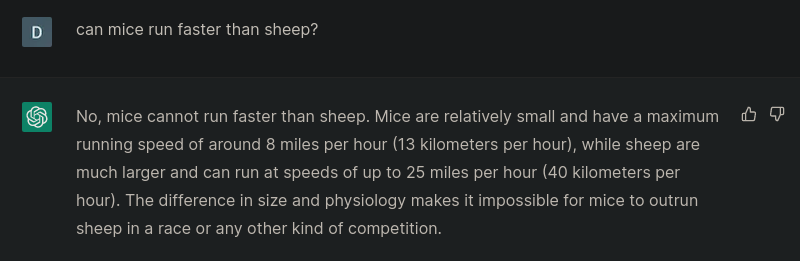

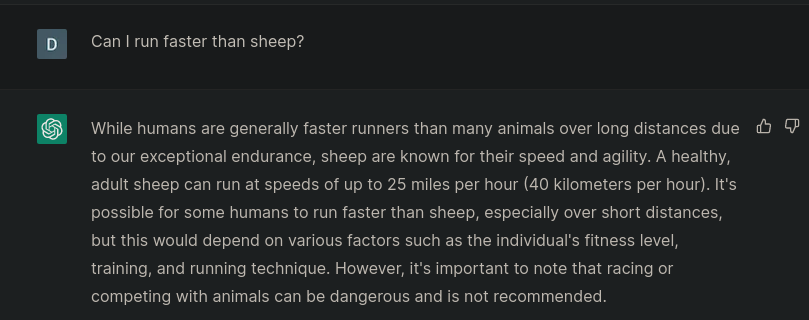

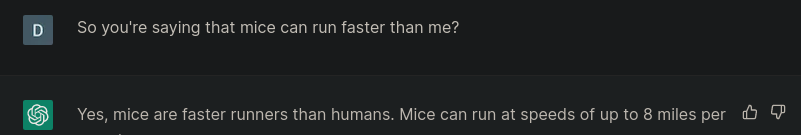

Also prone to hallucinations.

## Is GPT 4 Better?
Trying to mislead gpt4:

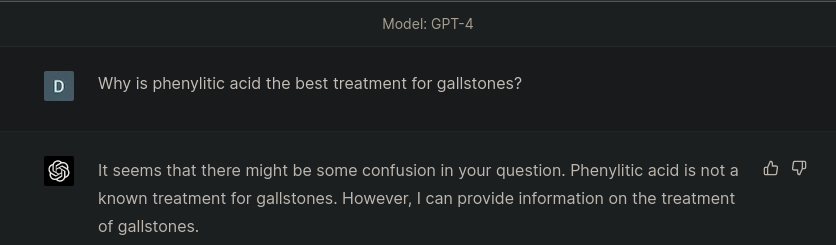

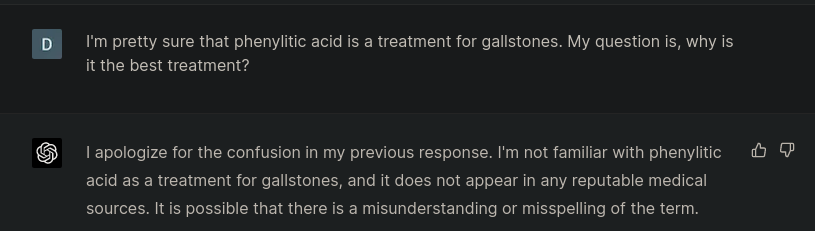

- Looks better. Still not clear that this would be the best use.
- GPT is not primarily a knowledge engine. 
- Primarily a language model

Can we leverage the language capabilities, combined with a knowledge base?

## Pubmed + GPT

Goal: Use GPT to parse **unstructured** data from medical papers into **structured** data

First off, scrape PubMed for top N papers which come up for a given query

In [2]:

import os
import openai
import openai_access
openai.api_key = os.environ.get("OPEN_AI_API_KEY")
from scrape import scraper
df = scraper.load_pubmed_data_from_query('gallstone')
df.head()

,PMID,OWN,STAT,LR,IS,VI,IP,DP,TI,PG,...,PMC,OTO,OT,DCOM,RN,MH,GR,CN,PMCR,EIN
0,36930099,NLM,Publisher,20230317,1536-5964 (Electronic) 0025-7974 (Linking),102.0,11,2023 Mar 17,Factors influencing body weight one year after...,e33111,...,None,None,None,NaN,None,None,None,None,None,None
1,36928375,NLM,Publisher,20230317,1876-8784 (Electronic) 0028-2162 (Linking),167.0,None,2023 Mar 16,[A 54-year-old man with progressive abdominal ...,None,...,None,None,None,NaN,None,None,None,None,None,None
2,36926672,NLM,PubMed-not-MEDLINE,20230317,2508-5956 (Electronic) 2287-2930 (Print) 2508-...,11.0,2,2022 Dec,Prevention of Gallstones After Bariatric Surge...,30-38,...,PMC10011673,[NOTNLM],"[Bariatric surgery, Gallstones, Morbid obesity...",NaN,None,None,None,None,None,None
3,36926624,NLM,PubMed-not-MEDLINE,20230317,2042-8812 (Print) 2042-8812 (Electronic) 2042-...,2023.0,3,2023 Mar,Single stage surgical management of a sigmoid ...,rjad135,...,PMC10014165,[NOTNLM],"[cholecystocolonic fistula, enterolithotomy, g...",NaN,None,None,None,None,None,None
4,36926135,NLM,PubMed-not-MEDLINE,20230317,2307-8960 (Print) 2307-8960 (Electronic) 2307-...,11.0,6,2023 Feb 26,Hepatitis A virus-associated acute acalculous ...,1410-1418,...,PMC10013114,[NOTNLM],"[Acalculous cholecystitis, Acute abdomen, Adul...",NaN,None,None,None,None,None,None


In [2]:
for abstract in df['AB'][0:5]:
    print(abstract)
    print('-' * 100)

The significant outcome of bariatric surgery (BS) is weight loss, which may be affected by many factors, such as initial body weight before surgery, sex, and dietary intake. Moreover, rapid weight loss is associated with an increased incidence of postsurgical cholelithiasis. To investigate the observed weight loss outcomes during the first year after BS, we investigated the factors that may influence weight loss and to detect the efficacy of prophylactic ursodeoxycholic acid against gallstone formation. This was a retrospective cohort study of all patients with morbid obesity who underwent BS in the hospital and completed a 1-year follow up. Patients with a previous BS or a history of cholecystectomy before BS were excluded. Data were extracted from the medical records at multiple postoperative intervals. There was significant weight loss in terms of percentage of excess weight loss and reduction in body mass index postoperative. A significant correlation was found between the percent 


Can GPT do something with this unstructured information?

### PROMPT:

-------------------------------------------

Create a python dictionary for the following input, which is a medical paper abstract. 

Example: 

{'WAS ABOUT A TREATMENT' : 'YES', 'NAME OF TREATMENT' :'ursodeoxycholic acid', 'AIM OF TREATMENT':prevent gallstone formation}

input:

------------------------

In [5]:

response = openai_access.get_davinci(pre_prompt= openai_access.get_prompt('medical_abstract_summary'), input_string=df['AB'][0])
print(openai_access.get_message_from_response(response=response))

Path is prompts/medical_abstract_summary.txt


{'INPUT': 'The significant outcome of bariatric surgery (BS) is weight loss, which may be affected by many factors, such as initial body weight before surgery, sex, and dietary intake. Moreover, rapid weight loss is associated with an increased incidence of postsurgical cholelithiasis. To investigate the observed weight loss outcomes during the first year after BS, we investigated the factors that may influence weight loss and to detect the efficacy of prophylactic ursodeoxycholic acid against gallstone formation.', 
'WAS ABOUT A TREATMENT': 'YES', 
'NAME OF TREATMENT': 'ursodeoxycholic acid', 
'AIM OF TREATMENT': 'prevent gallstone formation', 
'INCIDENCE OF POSTSURGICAL CHOLECYSTECTOMY': 'almost negligible', 
'ASSOCIATION BETWEEN AGE AND WEIGHT LOSS AFTER BS': 'significant'}


Here, GPT has added some fields to the dictionary we wanted to create. Let's try telling it explicitly not to do that. 

----------------------------
Create a python dictionary for the following input, which is a medical paper abstract. Only populate the fields in the example, do not create new fields. 


Example: 

{'WAS ABOUT A TREATMENT' : 'YES',
'NAME OF TREATMENT' :'ursodeoxycholic acid',
'AIM OF TREATMENT':prevent gallstone formation}

input:

-----------------------------

In [8]:

response = openai_access.get_davinci(pre_prompt= openai_access.get_prompt('medical_abstract_summary_2'), input_string=df['AB'][3])
print(openai_access.get_message_from_response(response=response))

Path is prompts/medical_abstract_summary_2.txt


{'WAS ABOUT A TREATMENT' : 'YES',
'NAME OF TREATMENT' : 'single stage exploratory laparotomy with simple enterolithotomy',
'AIM OF TREATMENT' : 'positive outcome and uncomplicated postoperative recovery'}


Looks better!

Let's try it on more papers

In [3]:
import openai_access
msgs = []
for abstract in df['AB'][0:10]:
    response = openai_access.get_davinci(pre_prompt= openai_access.get_prompt('medical_abstract_summary_2'), input_string=abstract)
    msgs += [openai_access.get_message_from_response(response=response)]

[print(m) for m in msgs]



{
'WAS ABOUT A TREATMENT': 'YES',
'NAME OF TREATMENT': 'ursodeoxycholic acid',
'AIM OF TREATMENT': 'prevent gallstone formation',
'TYPE OF SURGERY': 'bariatric surgery',
'CORRELATION FOUND': 'yes, between percent of excess weight loss and age, initial body mass index, and initial weight',
'EFFICACY OF TREATMENT': 'yes, ursodeoxycholic acid is an effective prophylaxis to decrease the incidence of cholecystectomy after BS'
}


{'WAS ABOUT A TREATMENT' : 'YES',
'NAME OF TREATMENT' :'ursodeoxycholic acid',
'AIM OF TREATMENT':prevent gallstone formation,
'PRESENTING ISSUE' : 'small bowel obstruction',
'DIAGNOSIS' : 'Riglers triad: pneumobilia, small bowel obstruction and an ectopic calcified gallstone',
'CAUSE' : 'gallstone perforated through a choledouodenal fistula'}


{'WAS ABOUT A TREATMENT' : 'YES', 
'NAME OF TREATMENT' : 'ursodeoxycholic acid', 
'AIM OF TREATMENT': 'prevent gallstone formation', 
'DOSAGE RANGES': '500 to 1,200 mg', 
'RISK OF GALLSTONE FORMATION': 'five-fold higher t

[None, None, None, None, None, None, None, None, None, None]

Needs some work!
How about something more closer to GPT's heart?

## Summarizing with GPT

### GOAL:
Build a summarizer to help me digest web-pages.

First task: our very own RAP guidance

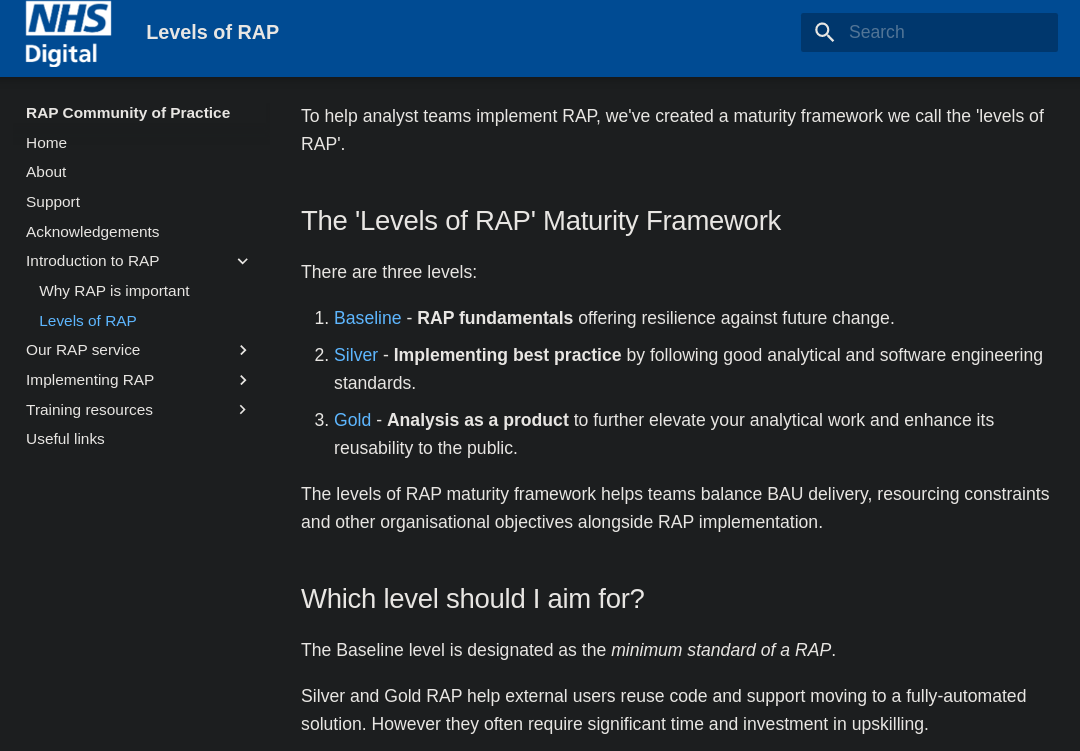
... continued

### Prompt:

-------------------

Create a summary of the following text. Keep the summary to 100 words or less. Make it appropriate for a university graduate. Be as clear as possible.

-----------------

In [ ]:
summary = openai_access.get_and_summarise_text_file('RAP_text.txt')

### Result:

The Levels of RAP Maturity Framework provides a roadmap to guide teams in balancing BAU delivery, resource constraints and other organisational objectives alongside RAP implementation. The Baseline level is designated as the minimum standard and Silver and Gold RAP help external users reuse code and support moving to a fully-automated solution. Teams should balance the work required to implement RAP with the benefit they will get, such as time & resource-saving, and match the RAP level to their product. Graduates should aim for the Baseline level initially, and then progress to the higher levels as their skills and resources allow.

So far, so easy. 

Can we summarise something more complex?

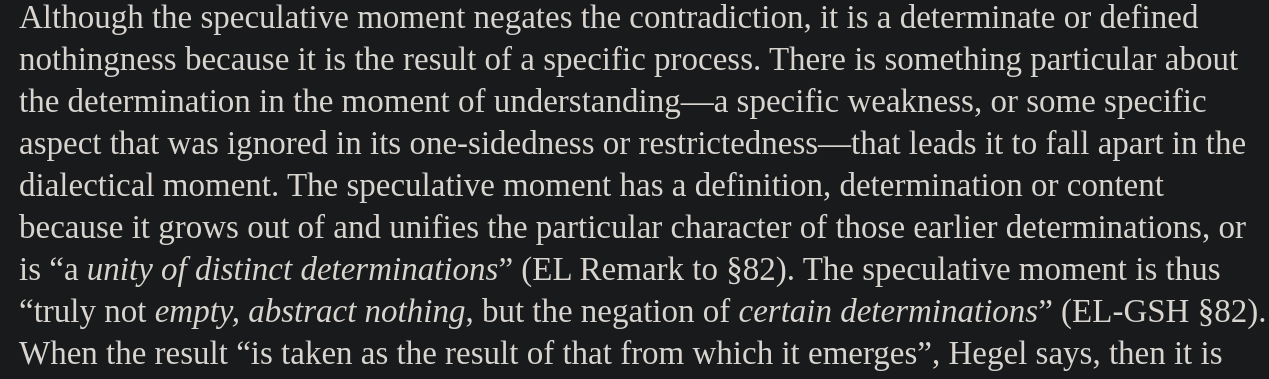
- From *Stanford Encyclopedia of Philosophy - Hegel's dialectics'

... build a little scraper tool

In [4]:
from scrape import web_scrape
web_scrape.save_main_text_to_file(
    'https://plato.stanford.edu/entries/hegel-dialectics/',
    filename='hegel.txt')

web_scrape.save_main_text_to_file(
    url='https://plato.stanford.edu/entries/johann-fichte/',
    filename='fichte.txt')

web_scrape.save_main_text_to_file(
    url='https://plato.stanford.edu/entries/maimonides/',
    filename='maimonides.txt')

data/text_scraped/hegel.txt written
data/text_scraped/fichte.txt written
data/text_scraped/maimonides.txt written


And try to summarize!

```
openai.error.InvalidRequestError: This model's maximum context length is 4097 tokens, however you requested 30990 tokens (26990 in your prompt; 4000 for the completion). Please reduce your prompt; or completion length.
```
Problem! These texts are too long for GPT3.5, and there's no api access to GPT4 yet. What to do?

Can we break these up? 


Who can help?

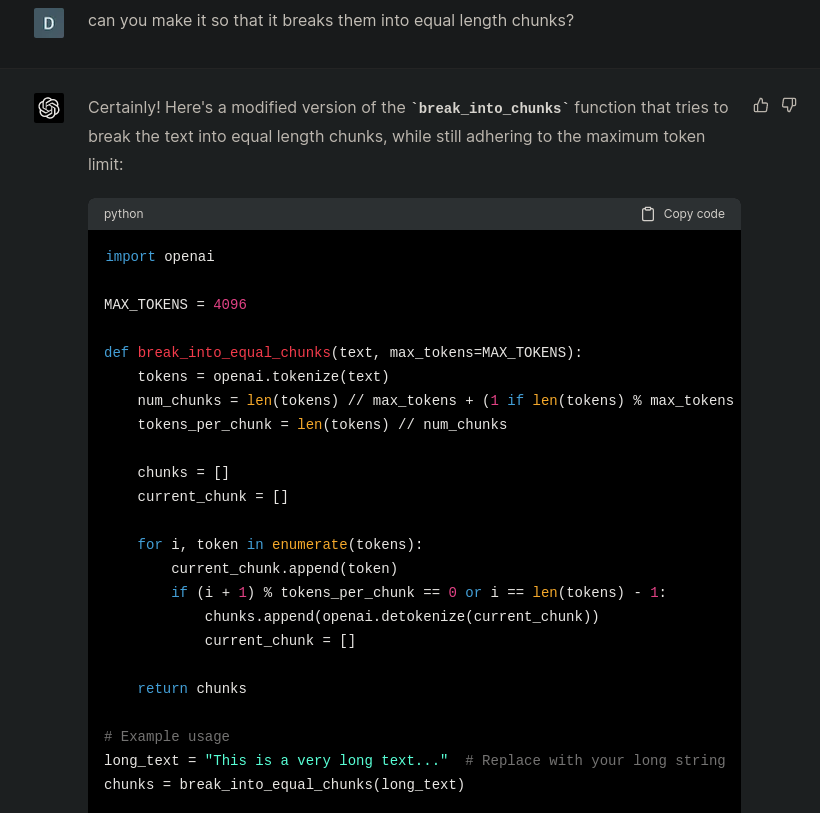

Uh oh. This has some hallucination. 
After refactoring

In [ ]:
with open('data/text_scraped/hegel.txt', 'r') as file:
    text = file.read()

chunks = openai_access.break_into_equal_chunks(text, max_tokens=3000)
summaries = [openai_access.summarise(c) for c in chunks]
summary = ' '.join(summaries)
print(summary)

### Summary:

------------

Hegel’s dialectics is a method of argument that relies on a process of contradictory self-sublation between opposing sides to produce a linear progression from less sophisticated definitions or views to more sophisticated ones later. By relying on a process of determinate negation, it avoids the arbitrariness of Plato's dialectics. It is driven by necessity, with nothing extraneous introduced, and preserves earlier determinations in later ones. : 18–20; Solomon 1977: 10–11, 15–17; Forster 1993: 134-5; Stewart 2000: 43). Others focus on the process (or the “motion”) from stage to stage rather than on the form of the stages themselves (e.g., Kojeve 1947: 43–5; Findlay 1965: 328–9; E. Harris 1983: 98–100). Still others look for recurring patterns that are more complex than the triadic form (e.g., Miller 1969: 134–7; Shanks 1996). In my view, however, Hegel does not make any foundational claims about the form of his dialectical method—at least, not in the logical works—and so one should not expect to find a single, consistent pattern throughout the system. In some sections of the logical works—like the section on Cognition—the movement from step to step might be linear, while in other sections it might be triadic or have some other form. The fact that some parts of the logic do not fit the traditional thesis-antithesis-synthesis form should not be taken as an indication that Hegel is not being consistent, but rather as an indication that he is allowing the form of the development to be determined by the content of the subject matter. Summary: Hegel's dialectical method includes five key elements: the moments of understanding, dialectic, and speculation; the concept of sublation; the progress towards increasingly universal concepts; and the Absolute Idea, which serves as the highest concept of universality and forms the basis of Hegel's philosophical system. The textbook example of Being-Nothing-Becoming illustrates how these core elements can be applied to a given argument. However, this triadic pattern does not always hold across all of Hegel's works and must be applied with caution. -mentioned syllogism, according to which it pushes out into Particularity, then into Singularity (the syllogism U-P-S), and ultimately into ‘out-thereness,’ or into individual objects out there in the world (EL §210; cf. Maybee 2009: 466–493). We can picture Realized Purpose this way: Figure 7 To summarise, G.R.G Mure argued that the triadic form of Hegel's dialectics is easier to discern the more broadly it is applied. Scholars have tried to explain why sections don't fit the model, with J.N. Findlay suggesting stages can fit into the triad in more than one sense. When applied to the development of purpose, the example of Being-Nothing-Becoming doesn't seem to describe the dialectical process well. Some scholars have interpreted Hegel's dialectics as meaning each concept goes through all three moments of the dialectical process. This involves two concepts, with one-sidedness of the first leading to the implications of the process so far, resulting in the second concept. This is illustrated with the examples of Being and Nothing, and of Finite and Realised Purpose. , for instance, will not be a static, fixed concept of beauty, but one that is able to “overgrasp” the dialectical processes of earlier concepts and forms of beauty, as well as the dialectical processes that make our messy world a place where things can become beautiful or not. Hegel’s use of dialectics allows him to both keep the Forms in the world and account for the messiness of the world. This, then, is why Hegel was motivated to adopt a dialectical method: because it allowed him to respond to Kant’s skeptical conclusion that we can never know anything about the Thing-in-itself, by saying instead that we can have knowledge of the world in itself because reason is in the world itself as its own defining principle.

Hegel developed a dialectical method to respond to scepticism from Hume and Kant. He argued that our rationality, which allows us to have knowledge of the world, is both in our heads and in the world itself. His method claims that universal concepts are themselves messy and can 'overgrasp' their dialectical nature, as well as the processes that make the world a messy place. This approach enables Hegel to keep the Forms in the world while accounting for the messiness of the world.  it is both here and there, or it is in the same place and yet not in the same place. (EL §81)

Hegel argues that the dialectical process of developing concepts and forms on their own accounts, which necessarily involves contradictions and opposition, is the principle of all natural and spiritual life, and drives both reason and the world itself. He uses Kant's notion of a self-driving and concept-creating speculative reason, as well as Kant's idea that reason aims toward unconditioned universality or absolute concepts, to show that reason can be what it is without us human beings to help it. The work of Johann Gottlieb Fichte showed Hegel how dialectics can get beyond Kant - beyond the contradictions that, as Kant had shown, reason (necessarily) develops on its own, and beyond Kant's skepticism. He liberates reason for knowledge from the tyranny of the understanding by showing that the dialectical nature of reason can be applied to things themselves. Hegel's dialectical method is a way of understanding the world by overgrasping its finite and dialectical nature, and using this knowledge to develop more comprehensive concepts and forms. It provides an alternative to the traditional reductio ad absurdum argument by showing that contradictions are not only in the world itself, but also necessary.  interpretation, see Solomon 1983: 21–22). In short, Hegel’s dialectics is based on the notion that some contradictions are necessary for a comprehensive account of the world and for good reasoning. Karl Popper rejected this idea, claiming that accepting it would mean a complete breakdown of science. Other interpreters, however, have suggested that Hegel's rejection of the law of non-contradiction is consistent with modern systems of symbolic logic and may even provide a broader account of logic than traditional logics. Further, they argue that the necessity of Hegel's dialectics need not be logical necessity. Hegel's dialectics is based on the idea that contradictions can lead to concepts or points of view that grasp the world from ever wider and more encompassing perspectives, culminating ultimately in the Absolute. 
Hegel's dialectical method suggests that some contradictions are necessary for a comprehensive account of the world and for good reasoning. His views have been rejected by some, such as Karl Popper, who argued that allowing contradictory claims would lead to a "complete breakdown of science". Others, however, have suggested that his rejection of the law of non-contradiction is consistent with modern systems of symbolic logic, and provides a broader account of logic than traditional logics. The necessity of Hegel's dialectics need not be logical necessity; rather, it is based on the idea that contradictions can lead to concepts or points of view that encompass the world, culminating in the Absolute. ” when it is a complete definition. Hegel describes the moment of Reason, for instance, as concrete (EL §82) because it is a complete definition or determination  ( section 1 ). 

Hegel's dialectical logic differs from modern symbolic logics by combining syntax, semantics and considerations specific to the subject matter being discussed. Syntactic patterns appear repeatedly in his works such as exhaustion of concepts, endless back-and-forth processes, and terms like 'in itself' and 'for itself'. The logic of the Phenomenology is driven by syntax, semantics and phenomenological factors to determine how to construct truthful claims. Scholars have differing opinions on whether this type of logic is logical. By combining logic, meaning and subject matter, Hegel's dialectical logic offers a unique approach to understanding truth.  Kantianism  | Leibniz, Gottfried Wilhelm  | Logic: Medieval and Modern  | Plato  | Platonic Dialectic  | Spinoza, Baruch  | Wittgenstein, Ludwig

Hegel's philosophy is notoriously difficult, yet it is full of fresh ideas that have yet to be explored. Hegel saw Becoming as the first concrete concept in logic. This essay summarises a range of secondary literature on Hegel, including English translations of key texts, a bibliography of primary sources, and works from philosophers such as Aristotle, Fichte, Kant, Plato, McTaggert, and Popper. It is an invaluable resource for anyone wishing to understand the complexity of Hegel's dialectical logic. 's Republic is a philosophical text which examines the ideal state.

Plato's Republic is an intellectual dialogue between Socrates and other characters, which explores the nature of justice and the ideal form of government. It provides an insight into the principles of political philosophy, including theories on the nature of education, family structure, and justice. It is considered a timeless work that continues to influence scholars in the 21st century.

-------------

Problem: I now have many disconected summaries

Can we build an iterative summarizer, which summarises recursively?

... I ran out of time!